Text(0.5,1,u'GFS.csv')

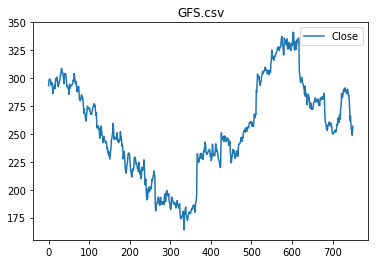

In [55]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np, numpy.random
import cvxopt as opt
from cvxopt import blas, solvers
import os, random

assets = [] # 3 random assets' expected return
# read a random file
rand_stocks = []
rand_stock = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock)
df1 = pd.read_csv('stock_dfs/'+rand_stock, usecols=['Date', 'Close'])
# df1 = pd.read_csv('stock_dfs/RRS.csv', usecols=['Date', 'Close'])
df1.plot()
plt.title(rand_stock)
# df1.head()

In [56]:
## use first half of 3 stocks to find expected return and covariances
# asset's first half expected return function
def half_expected_return(df, assets):
    df = df[:-len(df)/2] # drop second half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets.append(returns.mean())
    
    return returns
returns1 = half_expected_return(df1, assets)
# print returns1
print assets

[-0.0008078883395608382]


Text(0.5,1,u'IAG.csv')

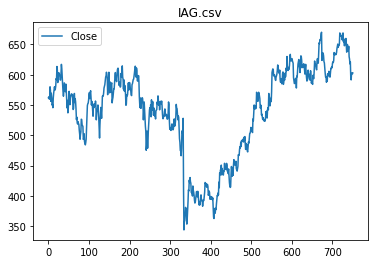

In [57]:
rand_stock2 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock2)
df2 = pd.read_csv('stock_dfs/'+rand_stock2, usecols=['Date', 'Close'])
# df2 = pd.read_csv('stock_dfs/III.csv', usecols=['Date', 'Close'])
df2.plot()
plt.title(rand_stock2)
# df2.head()

In [58]:
returns2 = half_expected_return(df2, assets)
print assets

[-0.0008078883395608382, -0.0013319133183678086]


[-0.0008078883395608382, -0.0013319133183678086, -0.0007346596493412729]


Text(0.5,1,u'WTB.csv')

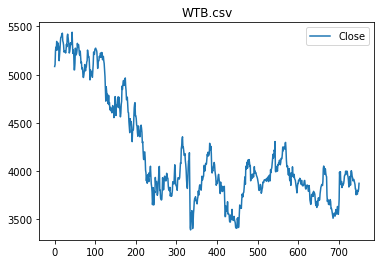

In [59]:
rand_stock3 = random.choice(os.listdir("stock_dfs/"))
rand_stocks.append(rand_stock3)
df3 = pd.read_csv('stock_dfs/'+rand_stock3, usecols=['Date', 'Close'])
# df3 = pd.read_csv('stock_dfs/ADM.csv', usecols=['Date', 'Close'])
returns3 = half_expected_return(df3, assets)
print assets
df3.plot()
plt.title(rand_stock3)

In [60]:
# find covariance of 3 assets
C = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C

[[0.00036357 0.00017191 0.00013141]
 [0.00017191 0.00075907 0.00030067]
 [0.00013141 0.00030067 0.00028863]]


     pcost       dcost       gap    pres   dres
 0:  9.5805e-04 -7.3330e+00  7e+00  1e-16  5e-16
 1:  9.5792e-04 -7.3634e-02  7e-02  3e-16  6e-16
 2:  9.4532e-04 -1.0239e-03  2e-03  2e-16  2e-17
 3:  4.1111e-04  1.3358e-04  3e-04  2e-16  1e-18
 4:  2.1280e-04  2.0708e-04  6e-06  3e-16  5e-20
 5:  2.1066e-04  2.1060e-04  6e-08  3e-16  2e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.1035e-03 -7.3331e+00  7e+00  1e-16  5e-16
 1:  1.1033e-03 -7.3890e-02  7e-02  2e-16  4e-16
 2:  1.0822e-03 -1.2387e-03  2e-03  2e-16  1e-17
 3:  7.0280e-04  3.6909e-04  3e-04  1e-16  3e-19
 4:  5.8374e-04  5.4921e-04  3e-05  2e-16  1e-19
 5:  5.7077e-04  5.6755e-04  3e-06  2e-16  8e-20
 6:  5.7040e-04  5.7027e-04  1e-07  2e-16  1e-19
 7:  5.7040e-04  5.7040e-04  1e-09  2e-16  4e-19
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  1.2489e-03 -7.3331e+00  7e+00  1e-16  2e-16
 1:  1.2486e-03 -7.4145e-02  8e-02  2e-16  6e-16
 2:  1.2172e-03 -1.4362e

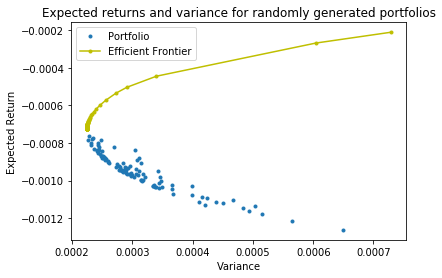

In [61]:
## find efficient frontier
# generate random portfolio, see random_portfolio notebook
np.random.seed(2) # fixed random seed
n_portfolio = 100 # number of portfolios
n_asset = len(assets) # number of assets 3
rand_matrix = np.random.random((n_portfolio, n_asset)) # generate random matrix
portfolio = np.zeros((n_portfolio, n_asset)) # create portfolios
i = 0
for row in rand_matrix: # each portfolio sum up to 1
    row_sum = np.sum(row)
    j = 0
    for col in row:
        portfolio[i][j] = col/row_sum
        j += 1
    i += 1
E = np.dot(portfolio, assets) # find expected return of each portfolio
variance = np.zeros((n_portfolio, 1)) # find variance of all portfolio
i = 0
for row in portfolio:
    variance[i] = np.dot(np.dot(row, C), row.T)
    i += 1
    
fig, ax = plt.subplots()
plotfolios = ax.plot(variance, E, 'o', markersize=3, label='Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for randomly generated portfolios')

N = 100
points = [t for t in range(N)] # find max return for 100 points
S = opt.matrix(C)
q = opt.matrix(assets, (3, 1)) # mean return of 3 assets

G = -opt.matrix(np.eye(n_asset)) # all 3 portions >= 0
oo = opt.matrix([-G, G], (6, 3))
h = opt.matrix(1.0, (6, 1))
A = opt.matrix(1.0, (1, n_asset)) # all 3 portions sum to 1
b = opt.matrix(1.0)

portfolios = [solvers.qp(x*S, -q, oo, h, A, b)['x'] for x in points]
returns = [blas.dot(q, x) for x in portfolios] # for each efficient portfolio
risks = [blas.dot(x, S*x) for x in portfolios]

frontier = ax.plot(risks, returns, 'y-o', markersize=3, label='Efficient Frontier')
ax.legend(loc='best')

In [62]:
assets2 = []
# take second half of assets
def half2_expected_return(df, assets):
    df = df[len(df)/2:] # drop first half
    returns = (df.Close - df.Close.shift(1))/df.Close
    returns = returns.dropna()
    assets2.append(returns.mean())
    return returns
returns1 = half2_expected_return(df1, assets2)
print assets2
# print returns1

[0.00016335647721260914]


In [63]:
returns2 = half2_expected_return(df2, assets2)
print assets2

[0.00016335647721260914, 0.0010036444320101461]


In [64]:
returns3 = half2_expected_return(df3, assets2)
print assets2

[0.00016335647721260914, 0.0010036444320101461, -0.00025947876243636556]


In [65]:
# find covariance of 3 assets second half
C2 = np.cov(np.array([returns1.values, returns2.values, returns3.values]))
print C2

[[2.23156671e-04 4.50321817e-05 3.79742696e-05]
 [4.50321817e-05 2.69080161e-04 6.43008274e-05]
 [3.79742696e-05 6.43008274e-05 1.88877351e-04]]


Text(0.5,1,u'Expected returns and variance for naive portfolios')

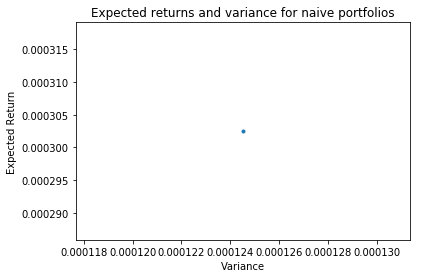

In [66]:
n_portfolio = 1 # number of portfolios
n_asset = len(assets2) # number of assets 3
naive = np.full((n_portfolio, n_asset), 1.0/3) # generate Naive Diversification
E = np.dot(naive, assets2) # find expected return of each portfolio
variance2 = np.dot(np.dot(row, C2), row.T) # find variance of all portfolio
variance2

fig2, ax2 = plt.subplots()
plotfolios2 = ax2.plot(variance2, E, 'o', markersize=3, label='Naive Portfolio')
plt.xlabel('Variance')
plt.ylabel('Expected Return')
plt.title('Expected returns and variance for naive portfolios')

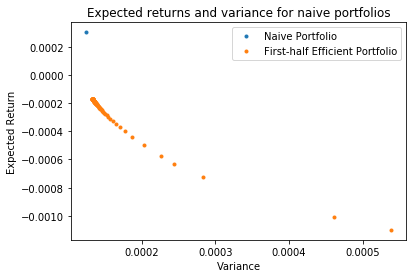

In [67]:
# apply first half efficient portfolios to second half
qn = opt.matrix(assets2, (3, 1))
Sn = opt.matrix(C2)
ef1 = [blas.dot(qn, x) for x in portfolios]
risks1 = [blas.dot(x, Sn*x) for x in portfolios]
ax2.plot(risks1, ef1, 'o', markersize=3, label='First-half Efficient Portfolio')
ax2.legend(loc='best')
fig2